# Natural Gas Predictor
## This notebook is designed to give some more insight to given data and try to train neural network with chosen attributes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from math import ceil, floor
import numpy as np
from sklearn.model_selection import train_test_split

FILE_URL = 'https://www.eia.gov/opendata/bulk/NG.zip'
SPOT_PRICE_DAILY_ID = 'NG.RNGWHHD.D'
ALL_IDS = [SPOT_PRICE_DAILY_ID, 'NG.NW2_EPG0_SNO_R33_BCF.W', 'NG.NW2_EPG0_SSO_R33_BCF.W', 'NG.NW2_EPG0_SWO_R31_BCF.W', 'NG.NW2_EPG0_SWO_R32_BCF.W', 'NG.NW2_EPG0_SWO_R33_BCF.W', 'NG.NW2_EPG0_SWO_R34_BCF.W', 'NG.NW2_EPG0_SWO_R35_BCF.W',
           'NG.NW2_EPG0_SWO_R48_BCF.W', 'NG.RNGC1.D', 'NG.RNGC2.D', 'NG.RNGC3.D', 'NG.RNGC4.D', 'NG.N9050US1.M', 'NG.N9050US2.M', 'NG.N9140US1.M', 'NG.N9140US2.M', 'NG.N9220US1.M', 'NG.N5020US2.M', 'NG.N9100US2.M', 'NG.N9130US2.M', 'NG.E_ERTWG_XWC0_NUS_C.M']

## Download latest version of natural gas info file and unzip it

In [2]:
import urllib.request

_ = urllib.request.urlretrieve(FILE_URL, "NG.zip")

In [3]:
from zipfile import ZipFile
  
with ZipFile("NG.zip", 'r') as nat_gas_zipped:
    nat_gas_zipped.extractall()

## Open the file and drop rows without data


In [4]:
with open("NG.txt", "r") as f:
    df = pd.read_json(f, lines=True)

In [5]:
df = df[df['data'].notna()]

In [6]:
df.columns

Index(['series_id', 'name', 'units', 'f', 'unitsshort', 'description',
       'copyright', 'source', 'start', 'end', 'last_updated', 'data',
       'iso3166', 'geography', 'geography2', 'category_id',
       'parent_category_id', 'notes', 'childseries'],
      dtype='object')

## Show series which are related to interesting data


In [7]:
def read_row_of_data(row_name=None, row_id=None, series_name=None):
    if row_name:
        row_filter = df['name'] == row_name
    elif row_id:
        row_filter = df['series_id'] == row_id
        row_name = df[row_filter]['name'].to_list()[0]
    data = df[row_filter]['data'].to_list()
    try:
        observation_dates = [datetime.datetime.strptime(
            el[0], '%Y%m%d').date() for el in data[0]]
    except ValueError as e:
        try:
            observation_dates = [datetime.datetime.strptime(
                el[0], '%Y%m').date() for el in data[0]]
        except ValueError as e:
            observation_dates = [datetime.datetime.strptime(
                el[0], '%Y').date() for el in data[0]]
    return pd.Series(
        data=[el[1] for el in data[0]], index=pd.DatetimeIndex(observation_dates), name=row_name)

In [8]:
# Looking for US NG Production data
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
    display(df[(df['name'].str.contains('U.S.')) & (df['name'].str.contains(
        'Production')) & (df['f'].isin(['D', 'W', 'M']))][['name', 'series_id']])

,name,series_id
1874,"U.S. Natural Gas Marketed Production, Monthly",NG.N9050US2.M
1942,"U.S. Natural Gas Marketed Production (Wet), Monthly",NG.N9050US1.M
1943,"U.S. Dry Natural Gas Production, Monthly",NG.N9070US1.M
1944,"U.S. Dry Natural Gas Production, Monthly",NG.N9070US2.M
2017,"U.S. Natural Gas Plant Liquids Production, Gaseous Equivalent, Monthly",NG.N9060US1.M
2018,"U.S. Natural Gas Plant Liquids Production, Monthly",NG.N9060US2.M


In [9]:
all_data_list = []
for name in df['name']:
    all_data_list.append(read_row_of_data(row_name=name))
all_data_df = pd.concat(all_data_list, axis=1, join='outer')

In [10]:
all_data_df = all_data_df.sort_index()
all_data_df = all_data_df.fillna(method='ffill')
all_data_df = all_data_df.loc[:, ~
                                     all_data_df.columns.duplicated()].copy()
all_data_df = all_data_df[~all_data_df[['Henry Hub Natural Gas Spot Price, Daily',
                                        'Natural Gas Futures Contract 1, Daily', 'Natural Gas Futures Contract 2, Daily']].isna().any(axis=1)]

In [11]:
len(all_data_df.columns)

15057

In [12]:
correlations_df = all_data_df.corrwith(other=all_data_df['Natural Gas Futures Contract 1, Daily'])

In [13]:
# show series that has strong correlation with price of natural gas

with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
    display(correlations_df.loc[(~correlations_df.index.str.contains('price')) & (~correlations_df.index.str.contains('Price')) & (~correlations_df.index.str.contains('Annual')) & ((correlations_df >= 0.7) | (correlations_df <= -0.7))])

Natural Gas Futures Contract 4, Daily                                       0.965610
Natural Gas Futures Contract 4, Weekly                                      0.960443
Natural Gas Futures Contract 1, Daily                                       1.000000
Natural Gas Futures Contract 1, Weekly                                      0.989922
Natural Gas Futures Contract 2, Daily                                       0.995374
Natural Gas Futures Contract 2, Weekly                                      0.987684
Natural Gas Futures Contract 3, Daily                                       0.983524
Natural Gas Futures Contract 3, Weekly                                      0.977216
Natural Gas Futures Contract 4, Monthly                                     0.957731
Natural Gas Futures Contract 1, Monthly                                     0.988755
Natural Gas Futures Contract 2, Monthly                                     0.985051
Natural Gas Futures Contract 3, Monthly                          

As you can see there are not too much Series with very strong (over 0.7 or under -0.7) correlation with NG price. Exports and imports to various countries are irrelevant because they are aggregated in total import/export series. I will add only "U.S. Natural Gas Exploratory and Developmental Wells Drilled, Monthly" series (as it contains also "U.S. Natural Gas Developmental Wells Drilled, Monthly" series) to my dataset.

In [14]:
# Searching for given series ID
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
    display(df[(df['name'].str.contains('U.S. Natural Gas Exploratory and Developmental Wells Drilled, Monthly'))][['name', 'series_id']])

,name,series_id
15224,"U.S. Natural Gas Exploratory and Developmental Wells Drilled, Monthly",NG.E_ERTWG_XWC0_NUS_C.M


## Plot data about daily prices during a year


In [15]:
price_df = read_row_of_data(row_id=SPOT_PRICE_DAILY_ID)
now_datetime = datetime.datetime.now()

In [16]:
grouped_price_df = price_df.groupby(price_df.index.year)

In [17]:
def get_prices_for_year(df, year):
    dr = pd.date_range(datetime.datetime(2000, 1, 1),
                       datetime.datetime(2000, 12, 31))
    curr_group = df.get_group(year)
    new_list = []
    for date in dr:
        query = curr_group[(curr_group.index.month == date.month) & (
            curr_group.index.day == date.day)]
        new_list.append(None if query.empty else query.iloc[0])
    return pd.Series(new_list, index=dr, name=year).dropna()

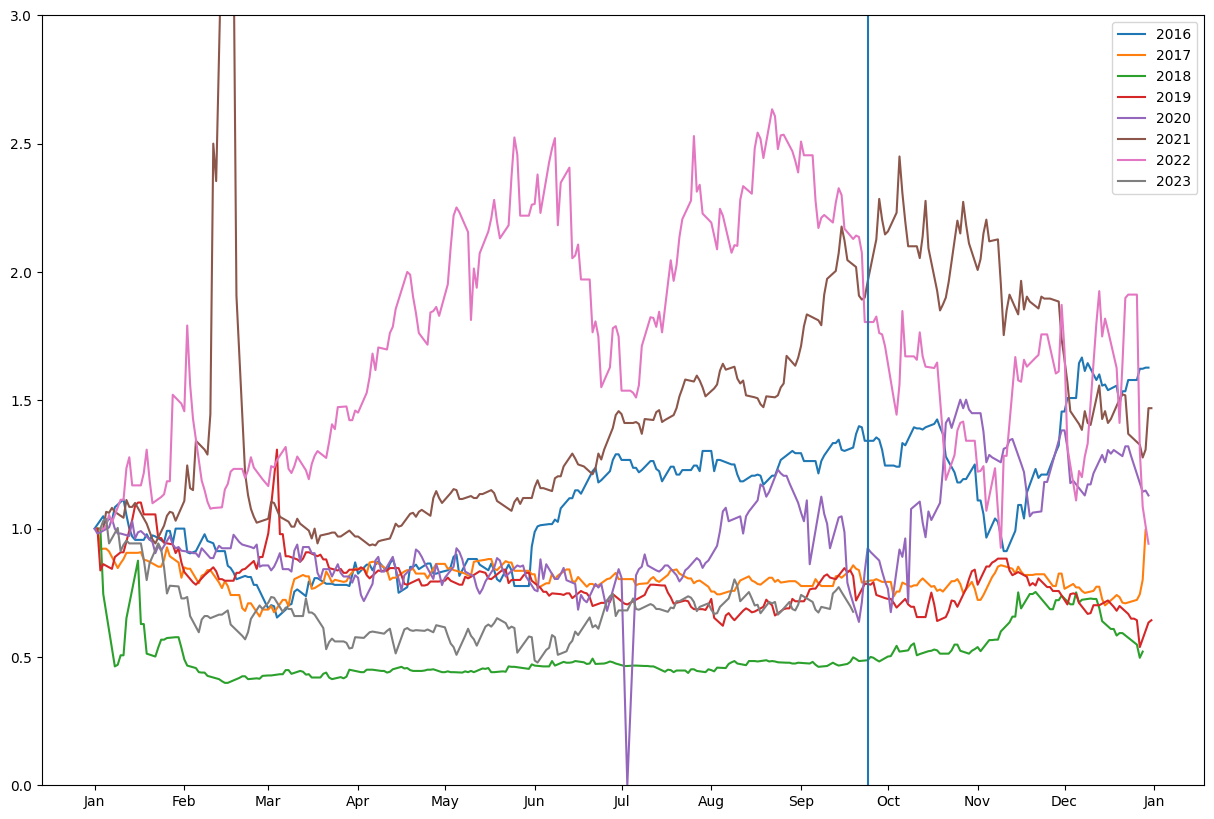

In [18]:
import matplotlib.dates as mdates

plt.figure(figsize=(15, 10))
for key in grouped_price_df.groups.keys():
    if key > 2015:
        md_prices = get_prices_for_year(grouped_price_df, key)
        md_prices = md_prices / md_prices.iloc[0]
        # plt.plot(grouped_price_df.get_group(key).index.to_series().apply(lambda s: datetime.date(1, s.month, s.day)), grouped_price_df.get_group(key))
        plt.plot(md_prices, label=str(key))
plt.ylim(0, 3)
plt.axvline(datetime.datetime(2000, now_datetime.month, now_datetime.day))
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.show()

In [19]:
all_years = []
years = []
for key in grouped_price_df.groups.keys():
    if key > 2015:
        md_prices = get_prices_for_year(grouped_price_df, key)
        md_prices = md_prices / md_prices.iloc[0]
        all_years.append(md_prices)
        # years.append(key)

all_years_df = pd.concat(all_years, axis=1)

In [20]:
# Sanity check
all_years_df.head()

,2016,2017,2018,2019,2020,2021,2022,2023
2000-01-01,1.000000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
2000-01-02,NaN,1.000000,1.000000,1.000000,0.980861,NaN,NaN,NaN
2000-01-03,NaN,0.919137,1.000000,0.836923,0.985646,NaN,1.000000,1.000000
2000-01-04,1.048246,0.921833,0.745192,0.861538,NaN,1.000000,0.997326,1.030220
2000-01-05,1.021930,0.921833,NaN,NaN,NaN,1.065385,1.010695,1.038462


In [21]:
all_years_df['mean'] = all_years_df.mean(axis=1, skipna=True)
all_years_df['min'] = all_years_df.min(axis=1, skipna=True)
all_years_df['max'] = all_years_df.max(axis=1, skipna=True)
all_years_df.sort_index()
start = all_years_df.index.searchsorted(datetime.datetime(2000, 4, 1))
end = all_years_df.index.searchsorted(datetime.datetime(2000, 5, 30))

Plotting min, mean and max prices through year

<Figure size 1500x1000 with 0 Axes>

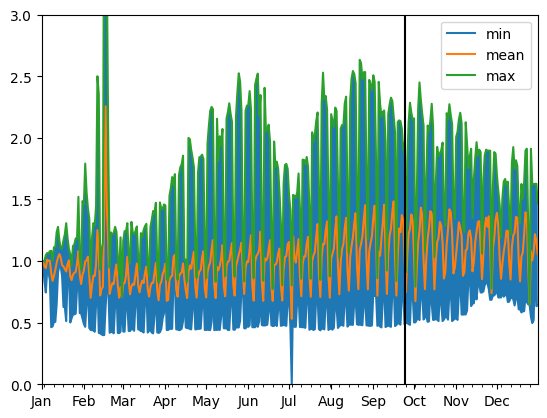

In [22]:
plt.figure(figsize=(15, 10))
all_years_df.plot(y=["min", "mean", "max"], kind="line")
plt.fill_between(all_years_df.index, all_years_df["min"], all_years_df["max"])
plt.ylim(0, 3)
plt.axvline(datetime.datetime(2000, now_datetime.month, now_datetime.day), color='black')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.show()

<Figure size 1500x1000 with 0 Axes>

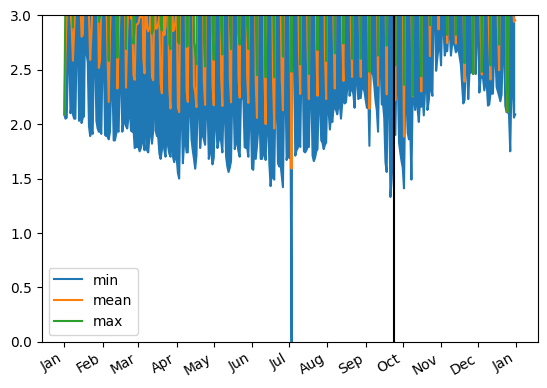

In [23]:
all_years = []
years = []
for key in grouped_price_df.groups.keys():
    if key > 2018:
        md_prices = get_prices_for_year(grouped_price_df, key)
        md_prices = md_prices
        all_years.append(md_prices)
        # years.append(key)

all_years_df = pd.concat(all_years, axis=1)

all_years_df['mean'] = all_years_df.mean(axis=1, skipna=True)
all_years_df['min'] = all_years_df.min(axis=1, skipna=True)
all_years_df['max'] = all_years_df.max(axis=1, skipna=True)
all_years_df.sort_index()
start = all_years_df.index.searchsorted(datetime.datetime(2000, 4, 1))
end = all_years_df.index.searchsorted(datetime.datetime(2000, 5, 30))

plt.figure(figsize=(15, 10))
all_years_df.plot(y=["min", "mean", "max"], kind="line")
plt.fill_between(all_years_df.index, all_years_df["min"], all_years_df["max"])
plt.ylim(0, 3)
plt.axvline(datetime.datetime(2000, now_datetime.month, now_datetime.day), color='black')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.show()

## Creating dataframe with chosen series ready for learning NN

In [24]:
chosen_data_list = []
for series_id in ALL_IDS:
    chosen_data_list.append(read_row_of_data(row_id=series_id))
chosen_data_df = pd.concat(chosen_data_list, axis=1, join='outer')

In [25]:
chosen_data_df = chosen_data_df.sort_index()
chosen_data_df = chosen_data_df.fillna(method='ffill')
chosen_data_df = chosen_data_df.loc[:, ~
                                     chosen_data_df.columns.duplicated()].copy()
chosen_data_df = chosen_data_df[~chosen_data_df[['Henry Hub Natural Gas Spot Price, Daily',
                                        'Natural Gas Futures Contract 1, Daily', 'Natural Gas Futures Contract 2, Daily']].isna().any(axis=1)]

In [26]:
# Adding properties of date as input data
chosen_data_df['Day of the week'] = chosen_data_df.index.dayofweek
chosen_data_df['Day'] = chosen_data_df.index.day
chosen_data_df['Month'] = chosen_data_df.index.month

Overview of chosen data

In [27]:
chosen_data_df.columns

Index(['Henry Hub Natural Gas Spot Price, Daily',
       'Weekly Nonsalt Region Natural Gas Working Underground Storage, Weekly',
       'Weekly Salt Region Natural Gas Working Underground Storage, Weekly',
       'Weekly East Region Natural Gas Working Underground Storage, Weekly',
       'Weekly Midwest Region Natural Gas Working Underground Storage, Weekly',
       'Weekly South Central  Region Natural Gas Working Underground Storage, Weekly',
       'Weekly Mountain Region Natural Gas Working Underground Storage, Weekly',
       'Weekly Pacific Region Natural Gas Working Underground Storage, Weekly',
       'Weekly Lower 48 States Natural Gas Working Underground Storage, Weekly',
       'Natural Gas Futures Contract 1, Daily',
       'Natural Gas Futures Contract 2, Daily',
       'Natural Gas Futures Contract 3, Daily',
       'Natural Gas Futures Contract 4, Daily',
       'U.S. Natural Gas Marketed Production (Wet), Monthly',
       'U.S. Natural Gas Marketed Production, Monthly

In [28]:
# Filtering out data before 2001 because they lack most of the informations
chosen_data_df = chosen_data_df[chosen_data_df.index >= datetime.datetime(2001, 1, 1)]

Plotting histograms and boxplots for chosen series

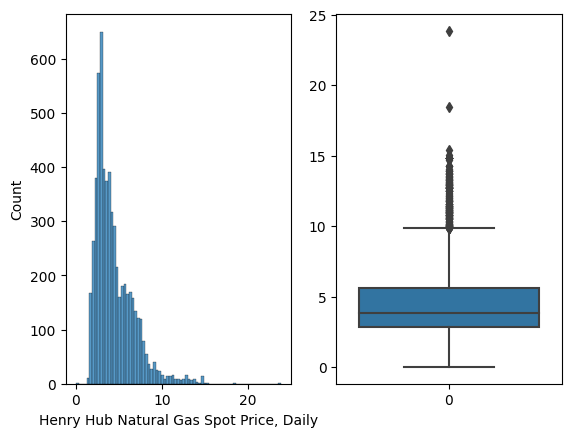

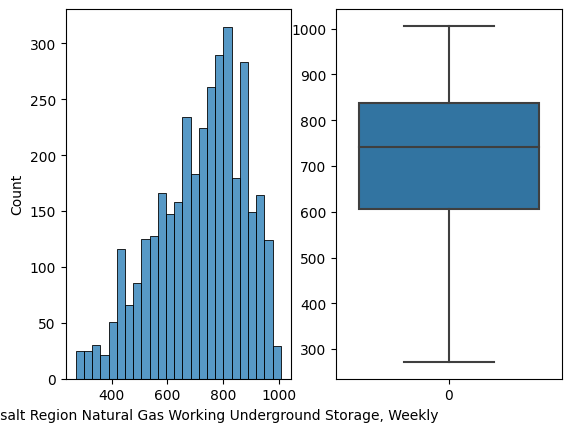

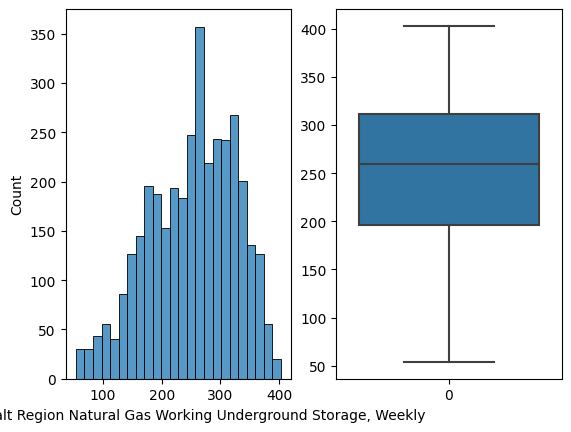

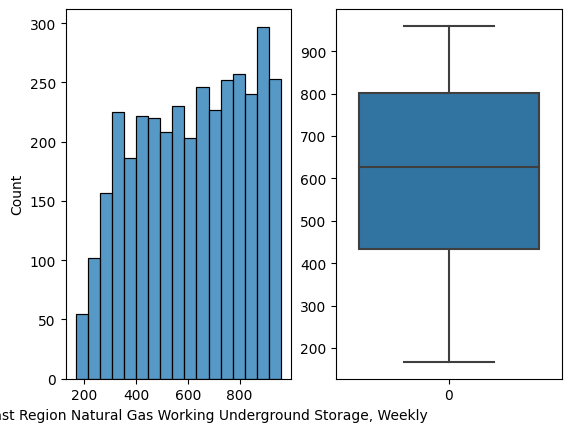

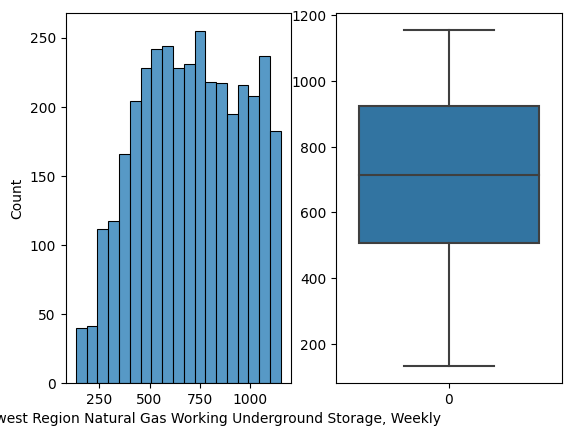

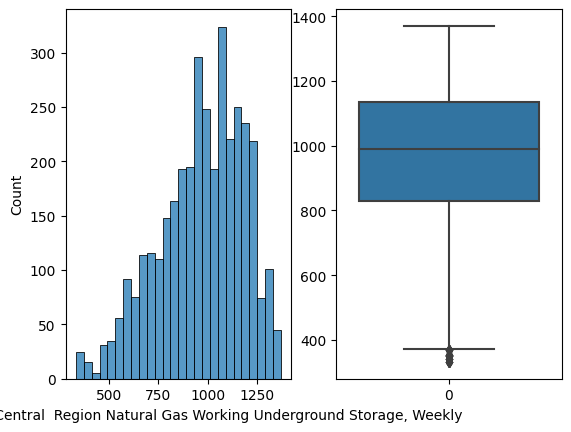

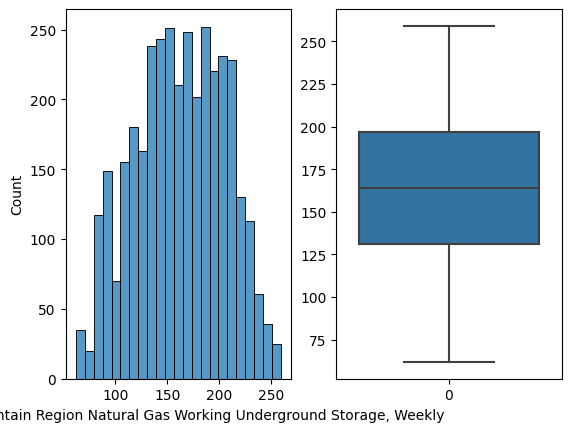

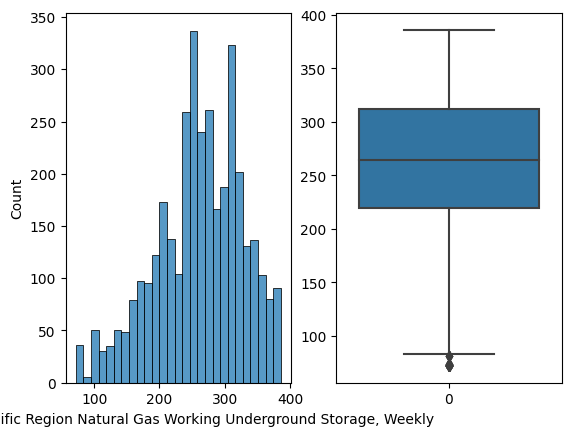

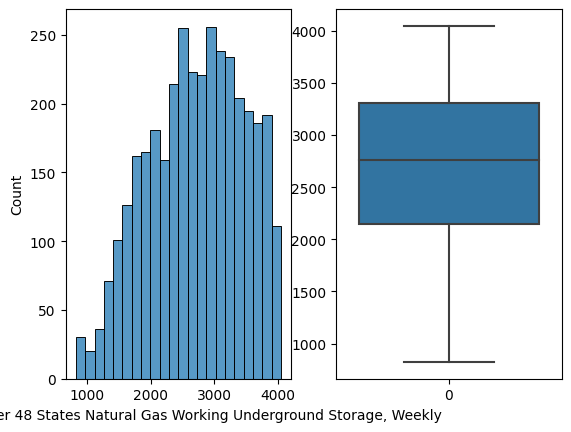

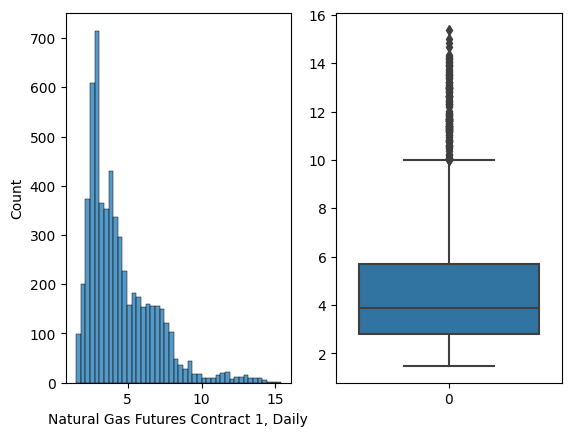

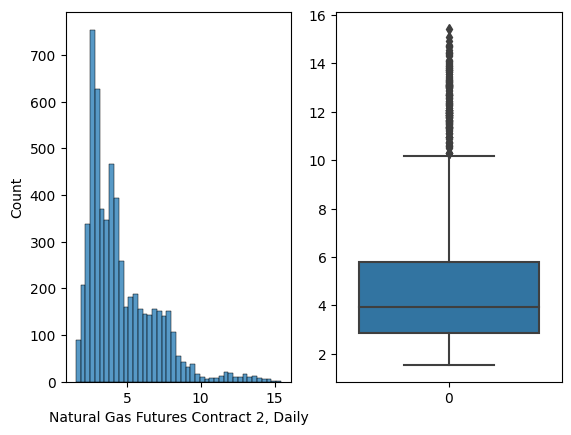

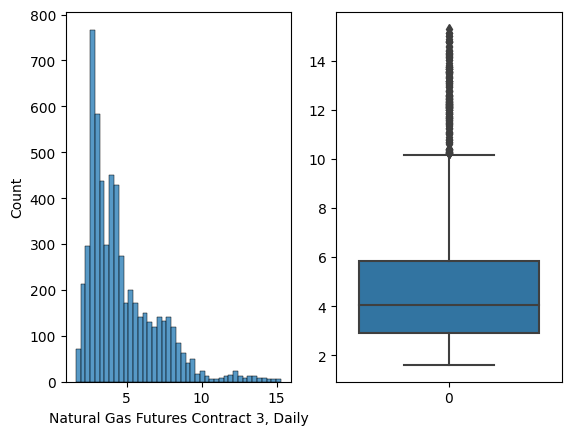

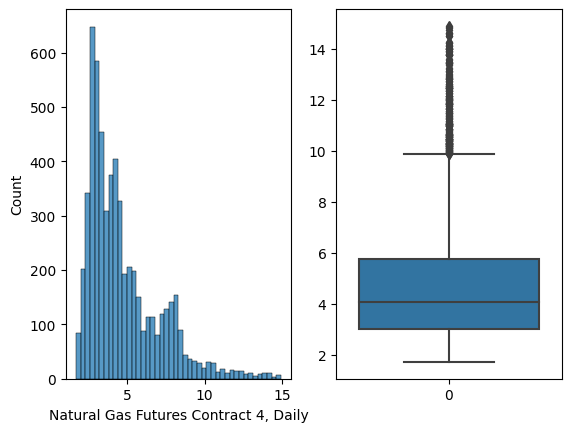

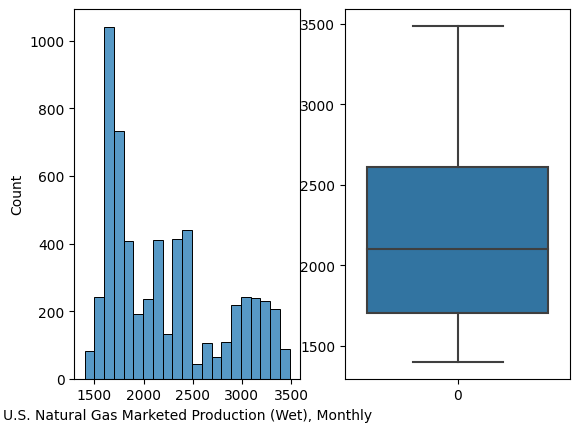

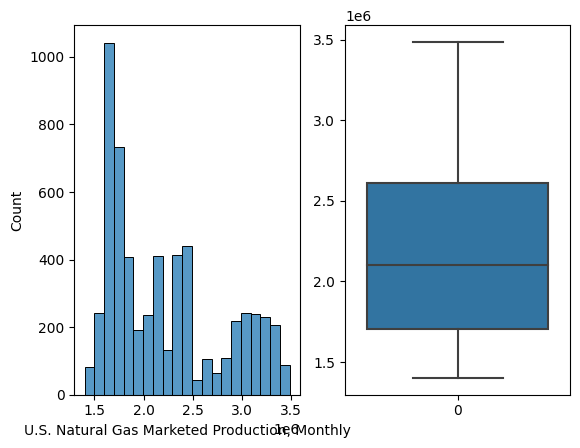

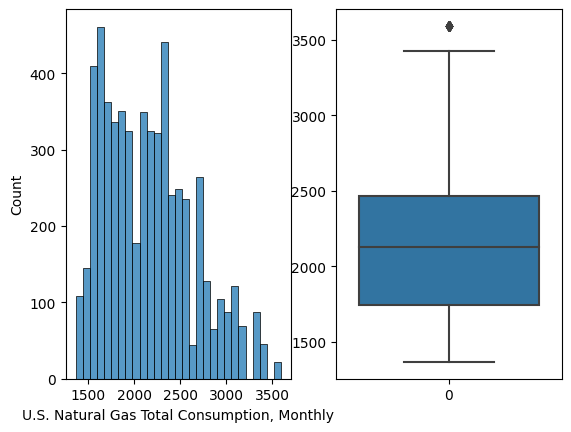

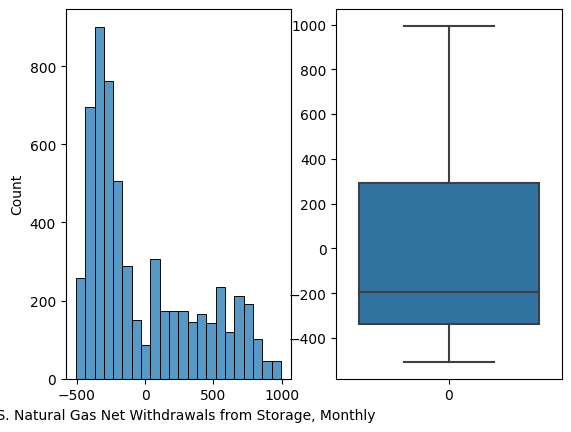

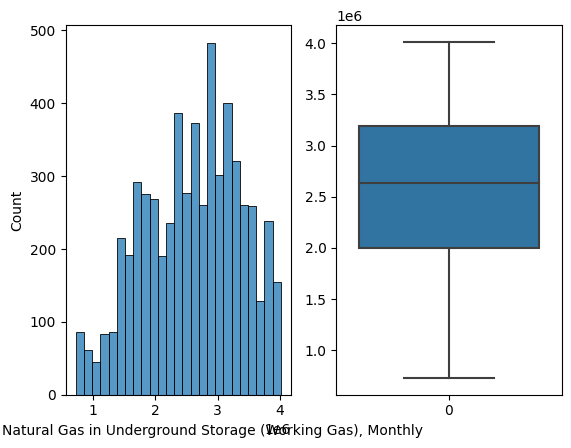

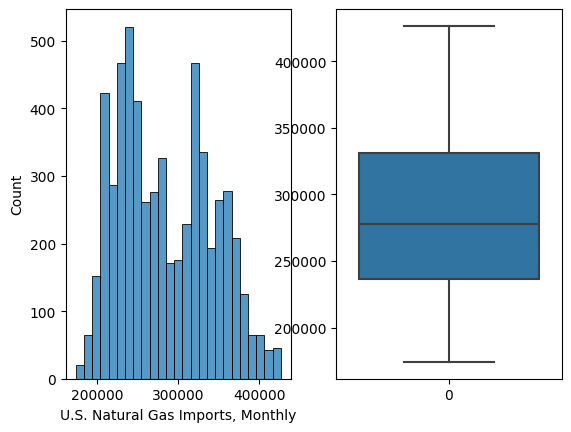

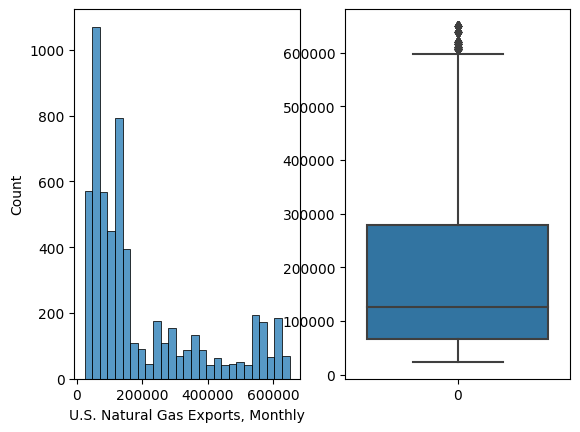

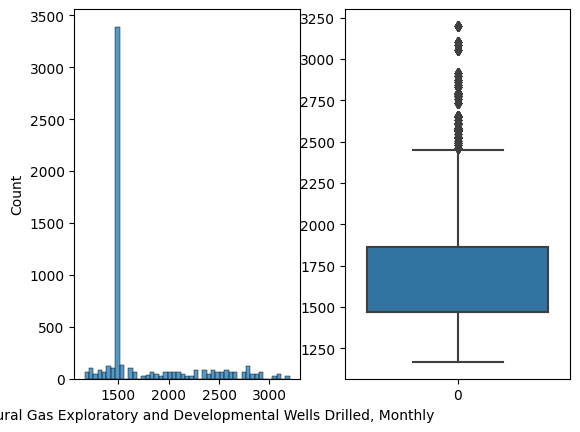

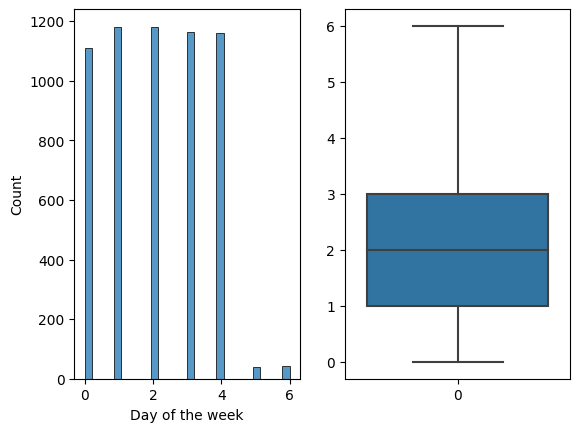

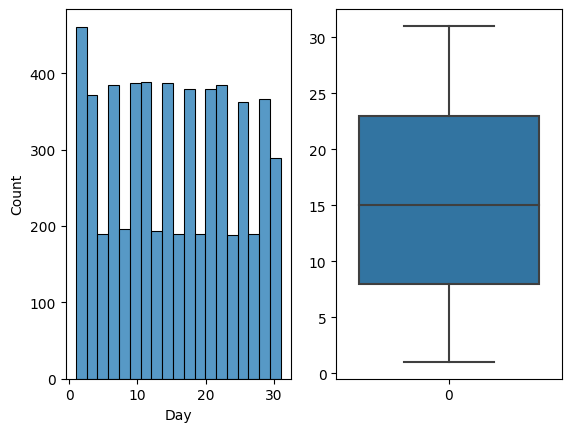

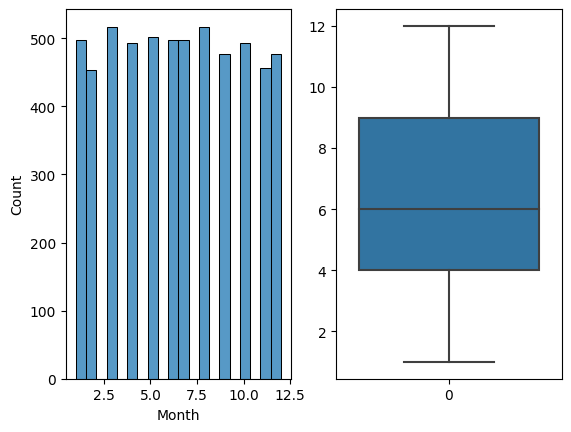

In [29]:
import seaborn as sns

for column in chosen_data_df.columns:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    sns.histplot(chosen_data_df[column], ax=ax1)
    sns.boxplot(chosen_data_df[column], ax=ax2)
    plt.show()

As you can see most of the data has more or less gaussian distribution.

Prices for different contracts as well as exports and number of wells drilled has significant number of outliers.

Scalling of data. As Prices and Exports series has a lot of outliers they need to be treated with robust scalling. Rest of data is scaled with standard scaler.

In [30]:
from sklearn import preprocessing

columns_for_robust_scalling = ['Henry Hub Natural Gas Spot Price, Daily',
                               'Natural Gas Futures Contract 4, Daily',
                               'Natural Gas Futures Contract 3, Daily',
                               'Natural Gas Futures Contract 2, Daily',
                               'Natural Gas Futures Contract 1, Daily',
                               'U.S. Natural Gas Exports, Monthly',
                               'U.S. Natural Gas Exploratory and Developmental Wells Drilled, Monthly']
other_columns = [
    column for column in chosen_data_df.columns if column not in columns_for_robust_scalling]
min_max_scaler = preprocessing.StandardScaler()
robust_scaler = preprocessing.RobustScaler(quantile_range=(0.0, 75.0))
robust_scaled_data = pd.DataFrame(robust_scaler.fit_transform(
    chosen_data_df[columns_for_robust_scalling]), columns=columns_for_robust_scalling, index=chosen_data_df.index)
min_max_scaled_data = pd.DataFrame(min_max_scaler.fit_transform(
    chosen_data_df[other_columns]), columns=other_columns, index=chosen_data_df.index)
chosen_data_df_scaled = pd.merge(robust_scaled_data, min_max_scaled_data, left_index=True, right_index=True)

In [31]:
# Adding target column to df - NG price in next session
chosen_data_df_scaled['Future 1 in one day'] = chosen_data_df['Natural Gas Futures Contract 1, Daily'].shift(
    -1) - chosen_data_df['Natural Gas Futures Contract 1, Daily']
# chosen_data_df_scaled['Future 1 in one day'] = chosen_data_df['Natural Gas Futures Contract 1, Daily'].shift(
#     -1)

In [32]:
chosen_data_df_scaled = chosen_data_df_scaled.fillna(0)

Creating plot of NG price depending on different series to see if there's any correlation

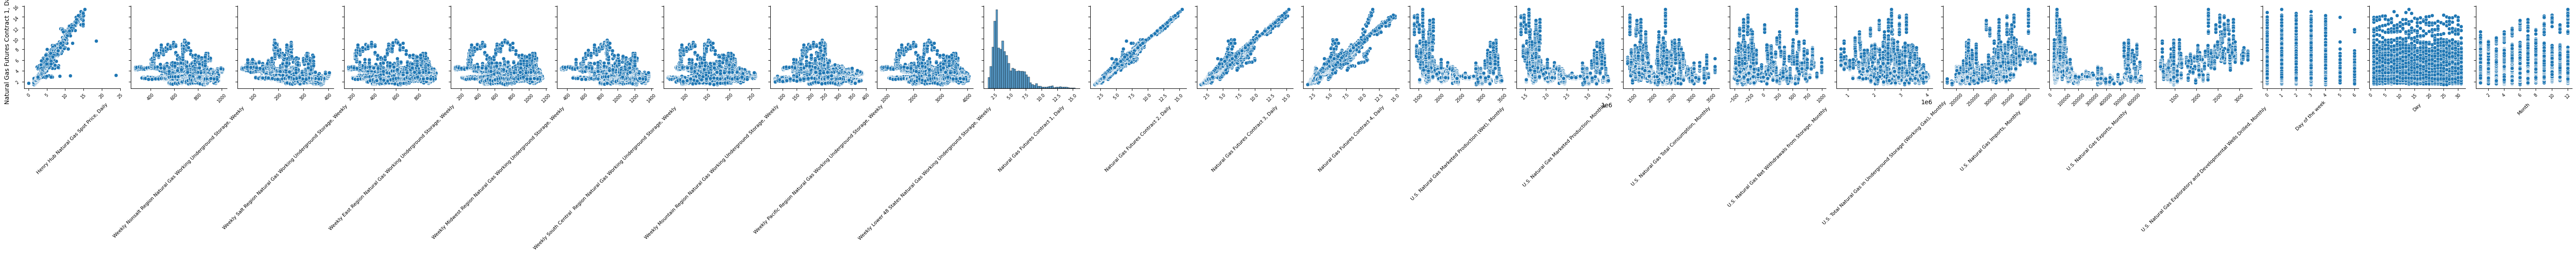

<Figure size 6000x250 with 0 Axes>

In [33]:
from IPython.display import Image

pp = sns.pairplot(data=chosen_data_df,
                  y_vars=['Natural Gas Futures Contract 1, Daily'],
                  x_vars=chosen_data_df.columns)
for ax in pp.axes.flat:
    ax.tick_params(labelrotation=45, labelsize=7)
    ax.set_xlabel(xlabel=ax.get_xlabel(), rotation=45, fontsize=8)
pp.savefig('Price correlations.png')

plt.clf()
Image(filename='Price correlations.png')

As you can see there's pretty much no visible relationships between series and price of given contract apart apart from other contracts.

In [34]:
# If you want bigger pair plot and more insight you can uncomment this one
# from IPython.display import Image
# import seaborn as sns
# import matplotlib.pyplot as plt 

# sns_plot = sns.pairplot(chosen_data_df_scaled, height=2.0)
# sns_plot.savefig("pairplot.png")

# plt.clf() # Clean parirplot figure from sns 
# Image(filename='pairplot.png') # Show pairplot as image

In [35]:
# Putting data into time series with batch containing 50 sessions

x_batches = np.array([chosen_data_df_scaled.iloc[i*50:].head(50).drop(columns=[
                     'Future 1 in one day']).values for i in range(floor(len(chosen_data_df_scaled)/50))])
y_batches = np.array([chosen_data_df_scaled['Future 1 in one day'].iloc[i*50:].head(
    50).values for i in range(floor(len(chosen_data_df_scaled)/50))])
y_batches = np.expand_dims(y_batches, -1)

In [36]:
# Splitting data into train, val and test sets in 80-10-10 ratio
x_train, x_val, y_train, y_val = train_test_split(
    x_batches, y_batches, test_size=0.2)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5)

In [37]:
import tensorflow as tf

# Metric to check if prediction was in the right direction (ie price goes up or down)
def sign_metric(y_true, y_pred):
    return tf.reduce_mean(tf.cast((((y_true== y_pred) & (y_true==0)) | (y_true*y_pred>0)), tf.float32), axis=-1)

Creating model with early stopping and checkpointing to predict NG price change. I tried various amount of LSTM cells in process but they gave pretty much the same results.

In [121]:
inputs = tf.keras.Input(shape=(x_train.shape[1], x_train.shape[2]))
x = tf.keras.layers.LSTM(2, return_sequences=True, stateful=False)(inputs)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=1e-4), loss="mae", metrics=[sign_metric])
history = model.fit(x_train, y_train, batch_size=2, epochs=500, validation_data=(x_val, y_val), callbacks=[tf.keras.callbacks.EarlyStopping(patience=10), tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_sign_metric', save_best_only=True, save_weights_only=True, mode='max')])
model.load_weights('best_model.h5')

Epoch 1/500
47/47 [==============================] - 3s 23ms/step - loss: 0.3803 - sign_metric: 0.4843 - val_loss: 0.3638 - val_sign_metric: 0.5067
Epoch 2/500
47/47 [==============================] - 1s 14ms/step - loss: 0.3730 - sign_metric: 0.4839 - val_loss: 0.3570 - val_sign_metric: 0.5067
Epoch 3/500
47/47 [==============================] - 1s 14ms/step - loss: 0.3662 - sign_metric: 0.4822 - val_loss: 0.3501 - val_sign_metric: 0.5067
Epoch 4/500
47/47 [==============================] - 1s 15ms/step - loss: 0.3593 - sign_metric: 0.4819 - val_loss: 0.3438 - val_sign_metric: 0.5067
Epoch 5/500
47/47 [==============================] - 1s 14ms/step - loss: 0.3524 - sign_metric: 0.4826 - val_loss: 0.3373 - val_sign_metric: 0.5067
Epoch 6/500
47/47 [==============================] - 1s 14ms/step - loss: 0.3460 - sign_metric: 0.4824 - val_loss: 0.3307 - val_sign_metric: 0.5017
Epoch 7/500
47/47 [==============================] - 1s 15ms/step - loss: 0.3394 - sign_metric: 0.4822 - val_los

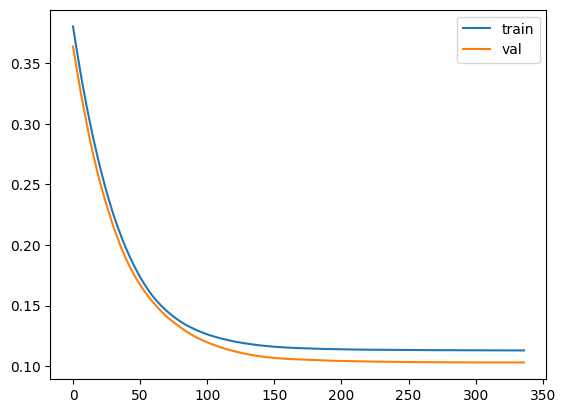

In [123]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'val'])
plt.show()

In [124]:
model.evaluate(x_test, y_test)
y_hat_test = model.predict(x_test)

1/1 [==============================] - 0s 376ms/step


As evaluation on test set shows - this model has MAE's value of 0.41 which is very big and on top of that it correctly predicts direction of change of price only in 47% of cases. It is much too inaccurate to use it in some sort of trading help.

I will try to get more insight to results in following cells

In [132]:
standarized_price = x_test[:,:,4].ravel()
array_to_inverse = np.zeros((standarized_price.shape[0], 7))
array_to_inverse[:, 4] = standarized_price
current_prices = robust_scaler.inverse_transform(array_to_inverse)[:, 4]
next_day_prices = np.roll(current_prices, -1)
next_day_prices[-1] = np.NaN

In [133]:
unrolled_y_test = np.array(y_test).ravel()
unrolled_y_hat_test = np.array(y_hat_test).ravel()
comparision_columns = list(zip(unrolled_y_test, unrolled_y_hat_test, current_prices, next_day_prices, unrolled_y_test-unrolled_y_hat_test, (unrolled_y_test-unrolled_y_hat_test)/next_day_prices, unrolled_y_hat_test-np.roll(unrolled_y_test, -1), unrolled_y_test-np.roll(unrolled_y_test, -1), ((unrolled_y_test == unrolled_y_hat_test) | (unrolled_y_test*unrolled_y_hat_test>0))))
comparision_dataframe = pd.DataFrame(data=comparision_columns, columns=['true price change','prediction', 'current price', 'next day price', 'difference between true price and prediction','relative difference','predicted daily change','true daily change', 'is same direction?'])
display(comparision_dataframe.head(5))

,true price change,prediction,current price,next day price,difference between true price and prediction,relative difference,predicted daily change,true daily change,is same direction?
0,-0.004,0.437180,2.644,2.640,-0.441180,-0.167114,0.472180,0.031,False
1,-0.035,0.576727,2.640,2.605,-0.611727,-0.234828,0.468727,-0.143,False
2,0.108,0.140163,2.605,2.713,-0.032163,-0.011855,0.140163,0.108,True
3,0.000,0.133081,2.713,2.713,-0.133081,-0.049053,0.196081,0.063,False
4,-0.063,0.114075,2.713,2.650,-0.177075,-0.066821,0.084075,-0.093,False


In [138]:
print(len(comparision_dataframe.loc[(comparision_dataframe['relative difference'].abs() > 0.05) & (~comparision_dataframe['is same direction?'])]))
print(len(comparision_dataframe.loc[(comparision_dataframe['relative difference'].abs() > 0.05) & (comparision_dataframe['is same direction?'])]))

279
162


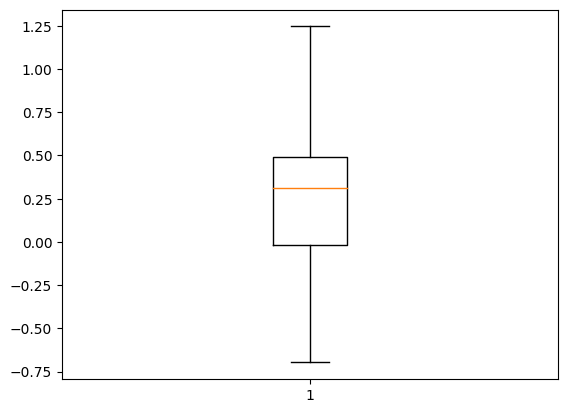

In [135]:
plt.boxplot(comparision_dataframe['difference between true price and prediction'], showfliers=False)
plt.show()

Relative mistakes higher than 5% occurs very often and more frequently with incorrect direction. Median of difference between true change and prediction is not even around 0

### As you can see - unfortunately this approach doesn't work. Chosen series of data provided by EIA isn't enough to predict change of NG price. 

Next I will try to approach this as classification problem (price go up/down/stay the same) and use all of the series provided in file.

## Classification approach

In [44]:
y_classes = np.concatenate((y_batches < 0, y_batches==0, y_batches>0),axis=-1).astype(np.int8)

# Splitting data into train, val and test sets in 80-10-10 ratio
x_class_train, x_class_val, y_class_train, y_class_val = train_test_split(
    x_batches, y_classes, test_size=0.2)
x_class_val, x_class_test, y_class_val, y_class_test = train_test_split(x_class_val, y_class_val, test_size=0.5)

In [57]:
inputs = tf.keras.Input(shape=(x_class_train.shape[1], x_class_train.shape[2]))
x = tf.keras.layers.LSTM(4, return_sequences=True, stateful=False)(inputs)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=1e-3), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.keras.metrics.CategoricalAccuracy()])
history = model.fit(x_class_train, y_class_train, batch_size=8, epochs=500, validation_data=(x_class_val, y_class_val), callbacks=[tf.keras.callbacks.EarlyStopping(patience=10), tf.keras.callbacks.ModelCheckpoint(filepath='best_class_model.h5', monitor='categorical_accuracy', save_best_only=True, save_weights_only=True, mode='max')])
model.load_weights('best_class_model.h5')

Epoch 1/500
12/12 [==============================] - 3s 64ms/step - loss: 1.0883 - categorical_accuracy: 0.4024 - val_loss: 1.0917 - val_categorical_accuracy: 0.4117
Epoch 2/500
12/12 [==============================] - 0s 19ms/step - loss: 1.0599 - categorical_accuracy: 0.4271 - val_loss: 1.0599 - val_categorical_accuracy: 0.4550
Epoch 3/500
12/12 [==============================] - 0s 19ms/step - loss: 1.0379 - categorical_accuracy: 0.4469 - val_loss: 1.0341 - val_categorical_accuracy: 0.4650
Epoch 4/500
12/12 [==============================] - 0s 20ms/step - loss: 1.0188 - categorical_accuracy: 0.4563 - val_loss: 1.0113 - val_categorical_accuracy: 0.4667
Epoch 5/500
12/12 [==============================] - 0s 19ms/step - loss: 1.0022 - categorical_accuracy: 0.4634 - val_loss: 0.9921 - val_categorical_accuracy: 0.4683
Epoch 6/500
12/12 [==============================] - 0s 21ms/step - loss: 0.9881 - categorical_accuracy: 0.4684 - val_loss: 0.9728 - val_categorical_accuracy: 0.4733
Epoc

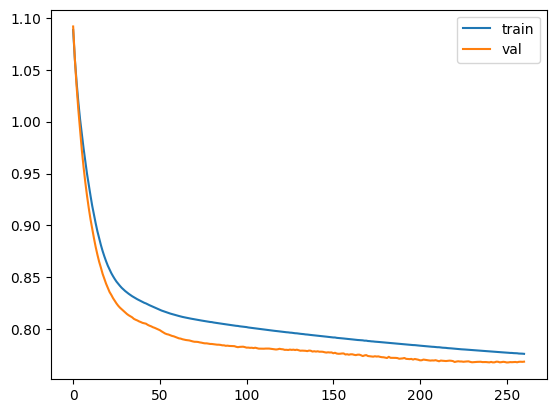

In [58]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'val'])
plt.show()

In [60]:
model.evaluate(x_class_test, y_class_test)

1/1 [==============================] - 0s 27ms/step - loss: 0.7830 - categorical_accuracy: 0.5017


[0.7829950451850891, 0.5016666650772095]

### This approach also doesn't work. It reaches accuracy over 50% but it's too small confidence to use this model

Let's try to use one last approach. Classification (as it's easier) with all the data provided by EIA

## Classification with all the data

In [61]:
from sklearn import preprocessing

columns_for_robust_scalling = ['Henry Hub Natural Gas Spot Price, Daily',
                               'Natural Gas Futures Contract 4, Daily',
                               'Natural Gas Futures Contract 3, Daily',
                               'Natural Gas Futures Contract 2, Daily',
                               'Natural Gas Futures Contract 1, Daily',
                               'U.S. Natural Gas Exports, Monthly',
                               'U.S. Natural Gas Exploratory and Developmental Wells Drilled, Monthly']
other_columns = [
    column for column in all_data_df.columns if column not in columns_for_robust_scalling]
min_max_scaler = preprocessing.StandardScaler()
robust_scaler = preprocessing.RobustScaler(quantile_range=(0.0, 75.0))
robust_scaled_data = pd.DataFrame(robust_scaler.fit_transform(
    all_data_df[columns_for_robust_scalling]), columns=columns_for_robust_scalling, index=all_data_df.index)
min_max_scaled_data = pd.DataFrame(min_max_scaler.fit_transform(
    all_data_df[other_columns]), columns=other_columns, index=all_data_df.index)
all_data_df_scaled = pd.merge(robust_scaled_data, min_max_scaled_data, left_index=True, right_index=True)

c:\Pliki\code\NaturalGasPredictor\venv\Lib\site-packages\sklearn\utils\extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Pliki\code\NaturalGasPredictor\venv\Lib\site-packages\sklearn\utils\extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Pliki\code\NaturalGasPredictor\venv\Lib\site-packages\sklearn\utils\extmath.py:1072: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [62]:
# Adding target column to df - NG price in next session
all_data_df_scaled['Future 1 in one day'] = all_data_df['Natural Gas Futures Contract 1, Daily'].shift(
    -1) - all_data_df['Natural Gas Futures Contract 1, Daily']
# chosen_data_df_scaled['Future 1 in one day'] = chosen_data_df['Natural Gas Futures Contract 1, Daily'].shift(
#     -1)

In [63]:
all_data_df_scaled = all_data_df_scaled.fillna(0)

In [71]:
# Putting data into time series with batch containing 50 sessions

all_data_x_batches = np.array([all_data_df_scaled.iloc[i*50:].head(50).drop(columns=[
                     'Future 1 in one day']).values for i in range(floor(len(all_data_df_scaled)/50))])
all_data_y_batches = np.array([all_data_df_scaled['Future 1 in one day'].iloc[i*50:].head(
    50).values for i in range(floor(len(all_data_df_scaled)/50))])
all_data_y_batches = np.expand_dims(all_data_y_batches, -1)

In [74]:
all_data_y_classes = np.concatenate((all_data_y_batches < 0, all_data_y_batches==0, all_data_y_batches>0),axis=-1).astype(np.int8)

# Splitting data into train, val and test sets in 80-10-10 ratio
all_data_x_class_train, all_data_x_class_val, all_data_y_class_train, all_data_y_class_val = train_test_split(
    all_data_x_batches, all_data_y_classes, test_size=0.2)
all_data_x_class_val, all_data_x_class_test, all_data_y_class_val, all_data_y_class_test = train_test_split(all_data_x_class_val, all_data_y_class_val, test_size=0.5)

In [76]:
all_data_x_batches.shape

(138, 50, 15057)

All data contains over 15000 attributes. Network has to be pretty large.

In [79]:
inputs = tf.keras.Input(shape=(all_data_x_class_train.shape[1], all_data_x_class_train.shape[2]))
x = tf.keras.layers.LSTM(128, return_sequences=True, stateful=False)(inputs)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=1e-3), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.keras.metrics.CategoricalAccuracy()])
history = model.fit(all_data_x_class_train, all_data_y_class_train, batch_size=8, epochs=500, validation_data=(all_data_x_class_val, all_data_y_class_val), callbacks=[tf.keras.callbacks.EarlyStopping(patience=10), tf.keras.callbacks.ModelCheckpoint(filepath='all_data_best_class_model.h5', monitor='categorical_accuracy', save_best_only=True, save_weights_only=True, mode='max')])
model.load_weights('all_data_best_class_model.h5')

Epoch 1/500
14/14 [==============================] - 11s 630ms/step - loss: 1.1650 - categorical_accuracy: 0.4700 - val_loss: 0.8735 - val_categorical_accuracy: 0.4943
Epoch 2/500
14/14 [==============================] - 9s 625ms/step - loss: 0.8784 - categorical_accuracy: 0.4802 - val_loss: 0.8680 - val_categorical_accuracy: 0.4557
Epoch 3/500
14/14 [==============================] - 9s 620ms/step - loss: 0.8565 - categorical_accuracy: 0.4909 - val_loss: 0.8577 - val_categorical_accuracy: 0.4257
Epoch 4/500
14/14 [==============================] - 9s 628ms/step - loss: 0.8452 - categorical_accuracy: 0.5000 - val_loss: 0.8510 - val_categorical_accuracy: 0.4686
Epoch 5/500
14/14 [==============================] - 9s 621ms/step - loss: 0.8435 - categorical_accuracy: 0.4915 - val_loss: 0.8531 - val_categorical_accuracy: 0.4271
Epoch 6/500
14/14 [==============================] - 9s 618ms/step - loss: 0.8404 - categorical_accuracy: 0.4978 - val_loss: 0.8542 - val_categorical_accuracy: 0.45

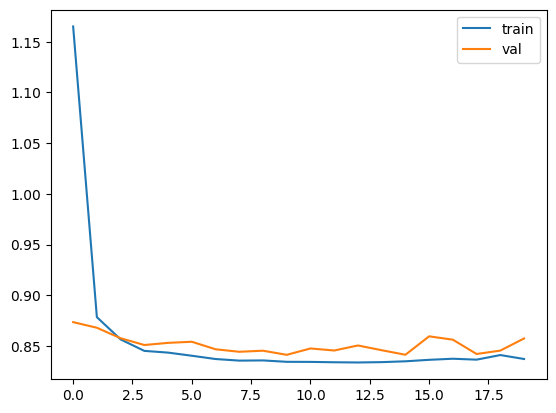

In [80]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'val'])
plt.show()

In [81]:
model.evaluate(all_data_x_class_test, all_data_y_class_test)

1/1 [==============================] - 0s 135ms/step - loss: 0.8585 - categorical_accuracy: 0.4643


[0.8585255742073059, 0.4642857015132904]

## As expected, using all of the possible data had negative effect on accuracy of prediction of price change. It is the worst model of all created in this notebook.

My understanding is that network had hard time recognizing which attributes were significant and choosing them. Smaller set of attributes gives better probability of getting better model as optimizer has smaller set of paths to go through to optimal solution.

# Summary

## It is not possible to predict Natural Gas price changes for next NYMEX session by using only EIA data.

### It seems like price depends more on speculation, geopolitical news and psychology than hard data about use and distribution of natural gas. Especially given the fact that data used here is registered in hindsight.

# Thank you for your attention